In [9]:
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt

In [15]:
import json
import sys
import logging 
import matplotlib.pyplot as plt
from collections import defaultdict
import scienceplots
import matplotlib as mpl


#mpl.rcParams.update(mpl.rcParamsDefault)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}
mpl.rc('font', **font)
plt.style.use(['science'])

In [3]:
netwrok_trace_type_mapping = {
    'timestamp': (1, 'Int64'),
    'size': (2, 'Int32'),
    'src_ip': (3, 'Int16'),
    'dest_ip': (4, 'Int16'),
    'src_port': (5, 'Int32'),
    'dest_port': (6, 'Int32'),
}
cols = list(netwrok_trace_type_mapping.keys())

In [7]:
df = pd.read_csv('../../data/pytorch-mingpt/node-0/packets', header=None, names=cols)
df = df.sort_values(by='timestamp')

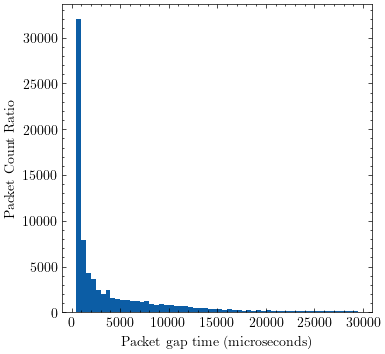

In [23]:
df = pd.read_csv('../../data/pytorch-mingpt/3/node-1/packets', header=None, names=cols, nrows=80000000)
df = df.sort_values(by='timestamp')
df = df[(df['src_ip'] == 134)]
times = df['timestamp'].values
gaps = (np.roll(times, -1) - times) / 1000
hist, bins = np.histogram(gaps, bins=np.arange(500, 30000, 500))
# hist = hist / len(gaps)
fig, ax = plt.subplots(figsize=(4, 4))
ax.bar(bins[:-1], hist, width=np.diff(bins), align="edge")
plt.xlabel('Packet gap time (microseconds)')
plt.ylabel('Packet Count Ratio')
# plt.title("Packet gap histogram")
plt.show()

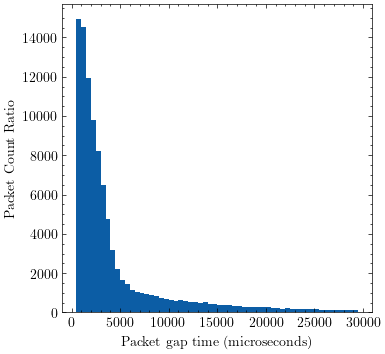

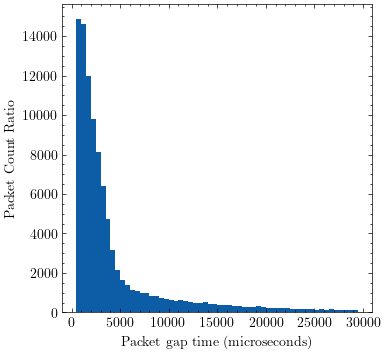

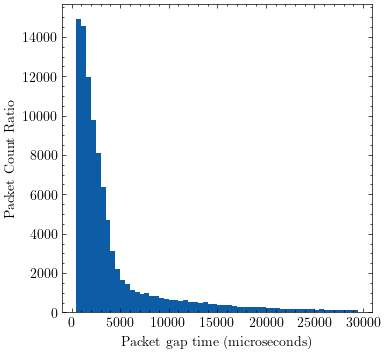

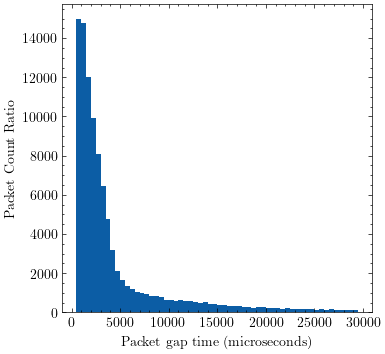

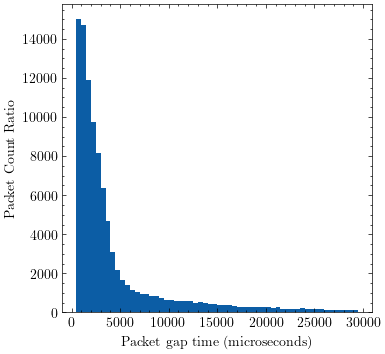

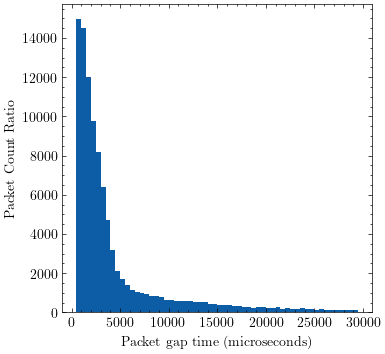

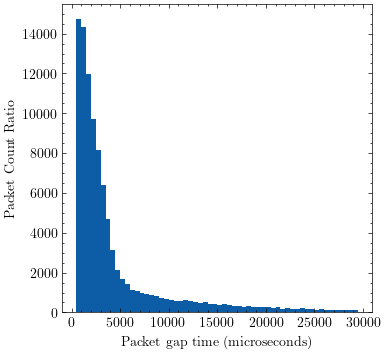

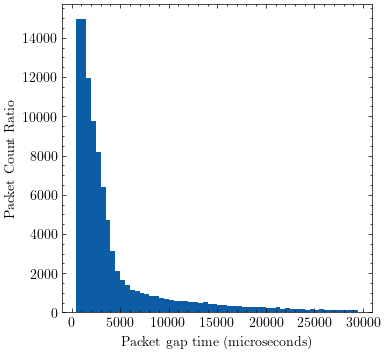

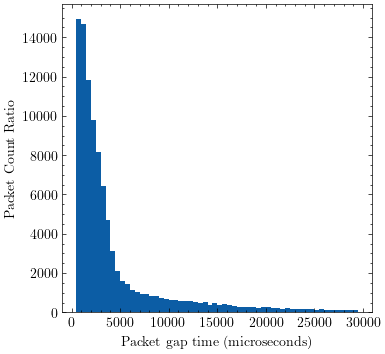

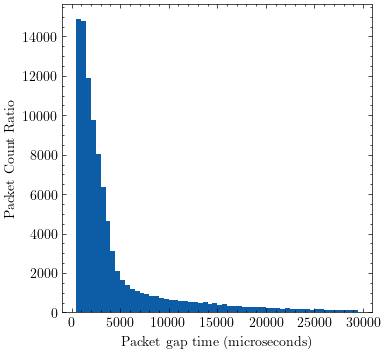

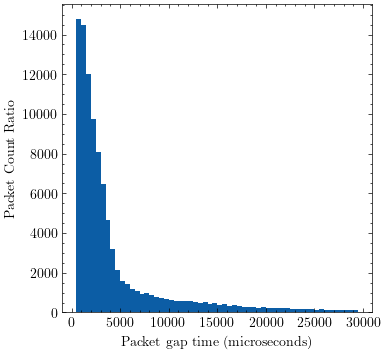

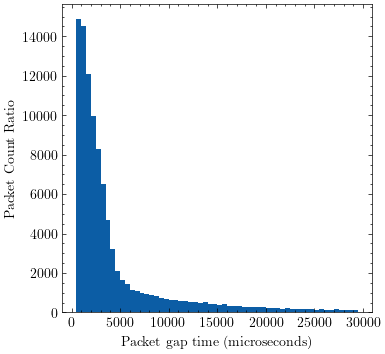

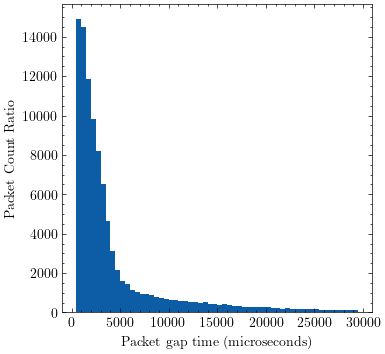

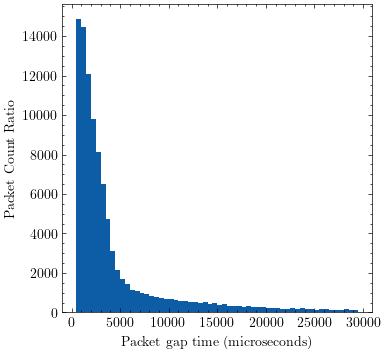

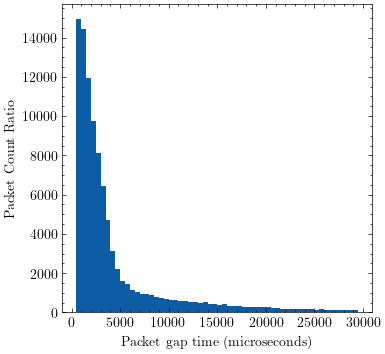

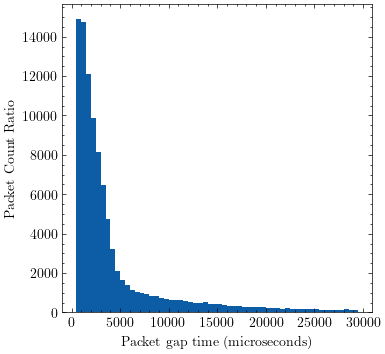

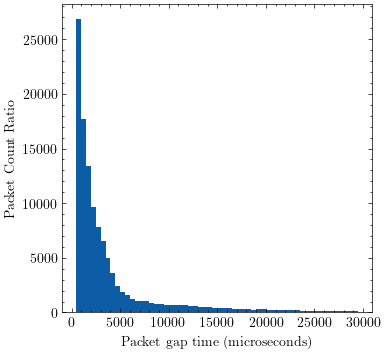

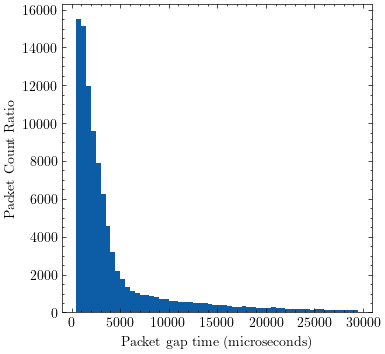

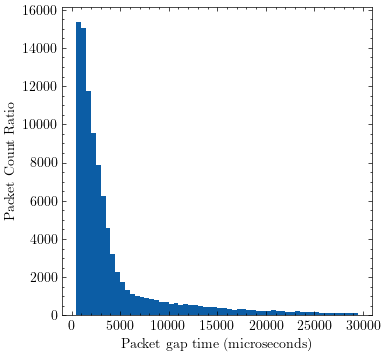

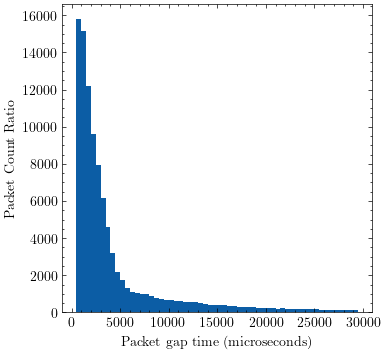

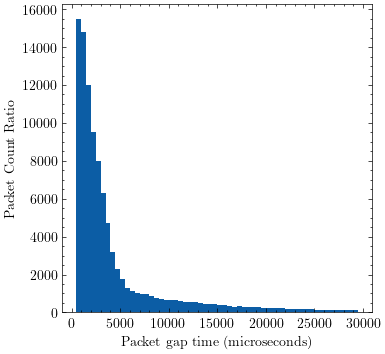

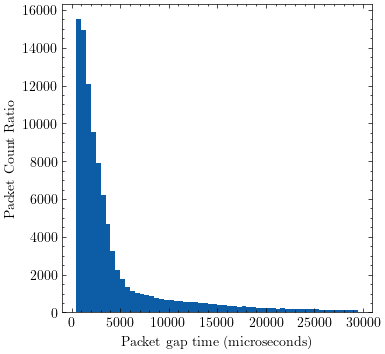

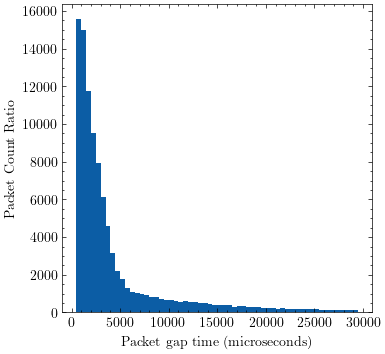

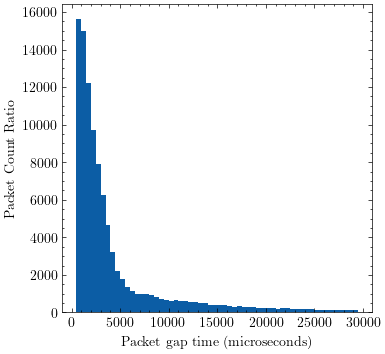

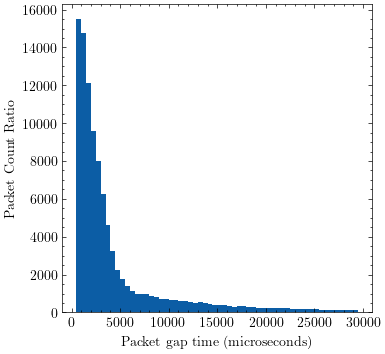

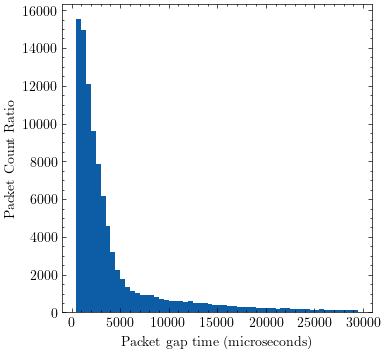

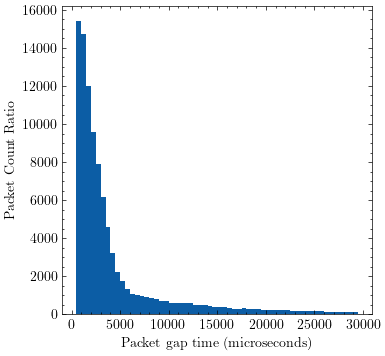

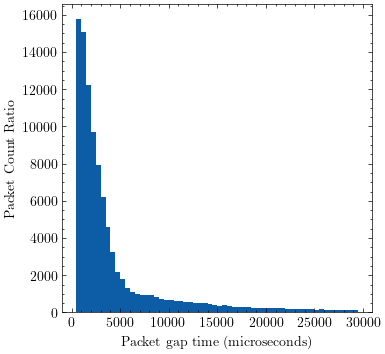

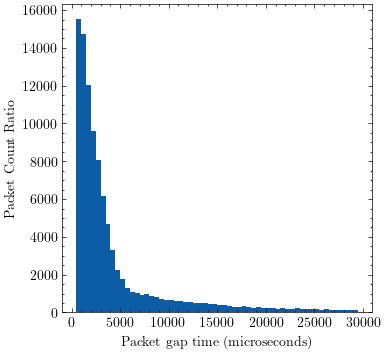

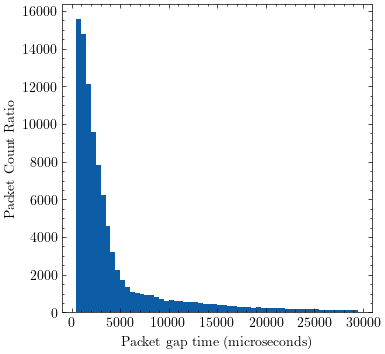

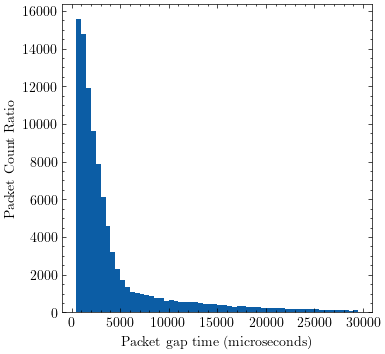

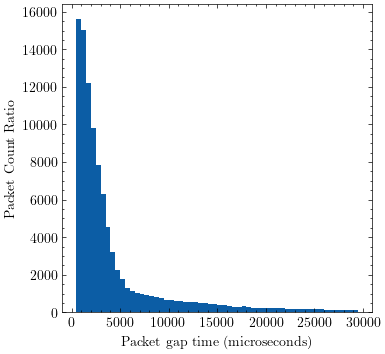

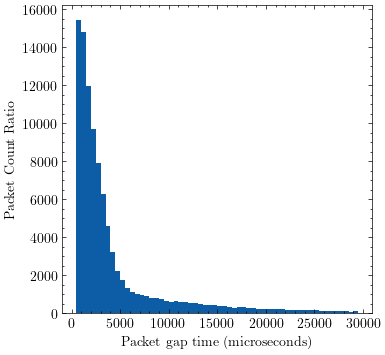

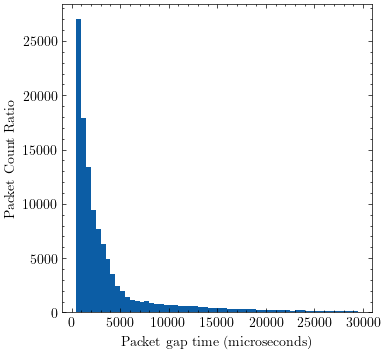

In [24]:
zf = pd.read_csv('../../data/pytorch-mingpt/3/node-1/packets', header=None, names=cols, nrows=80000000)
zf = zf.sort_values(by='timestamp')
zf = zf[(zf['src_ip'] == 134) & (zf['dest_ip'] == 123)]
tot = None
for (sp, dp), filtered_df in zf.groupby(['src_port', 'dest_port']):
    df = zf[(zf['src_port'] == sp) & (zf['dest_port'] == dp)]
    times = df['timestamp'].values
    gaps = (np.roll(times, -1) - times) / 1000
    hist, bins = np.histogram(gaps, bins=np.arange(500, 30000, 500))
    fig, ax = plt.subplots(figsize=(4, 4))
    if tot is None:
        tot = hist
    else:
        tot += hist
    ax.bar(bins[:-1], hist, width=np.diff(bins), align="edge")
    plt.xlabel('Packet gap time (microseconds)')
    plt.ylabel('Packet Count Ratio')
    # plt.title("Packet gap histogram")
    plt.show()
    


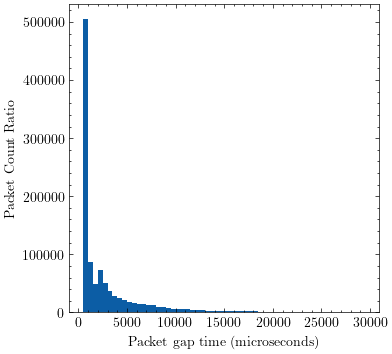

In [163]:
fig, ax = plt.subplots(figsize=(4, 4))    
ax.bar(bins[:-1], tot, width=np.diff(bins), align="edge")
plt.xlabel('Packet gap time (microseconds)')
plt.ylabel('Packet Count Ratio')
# plt.title("Packet gap histogram")
plt.show()

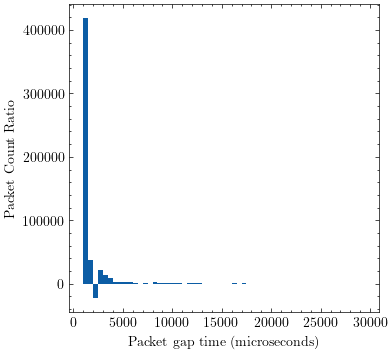

In [164]:
fig, ax = plt.subplots(figsize=(4, 4))    
ax.bar(bins[1:-1], (-np.diff(tot)), width=np.diff(bins[:-1]), align="edge")
plt.xlabel('Packet gap time (microseconds)')
plt.ylabel('Packet Count Ratio')
# plt.title("Packet gap histogram")
plt.show()

In [34]:
pd.set_option('display.max_rows', 500)

# df[df["dest_ip"] == 123].groupby(['src_port', 'dest_port']).mean().reset_index()
df[(df["dest_ip"] == 123)][df['size'] < 200].groupby(['src_port', 'dest_port']).mean().reset_index()

/tmp/ipykernel_4109548/4787303.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[(df["dest_ip"] == 123)][df['size'] < 200].groupby(['src_port', 'dest_port']).mean().reset_index()


,src_port,dest_port,timestamp,size,src_ip,dest_ip
0,48606,56597,1.697754e+18,70.000000,134.0,123.0
1,49774,60919,1.697754e+18,70.000052,134.0,123.0


In [13]:
df = pl.read_csv('../../data/pagerank/primary/packets', has_header=False, new_columns=cols)
df = df.sort(by='timestamp')
df = df.with_column(pl.col('timestamp') - pl.col('timestamp').min())
df = df.filter((pl.col('src_ip') == 2))
df = df.filter((pl.col('timestamp') > 1.8e12) & (pl.col('timestamp') < 1.95e12))

/tmp/ipykernel_2369121/3625008591.py:3: DeprecationWarning: `DataFrame.with_column` has been renamed; this redirect is temporary, please use `.with_columns` instead
  df = df.with_column(pl.col('timestamp') - pl.col('timestamp').min())


In [14]:
RES = 100000 # Nano Seconds
ts = df.select(pl.col("timestamp"))
vals = df.select(pl.col("size"))
ts = ts.to_numpy()
vals = vals.to_numpy()
x, y = [], []
start, end = ts[0], ts[-1]
starti, endi = start, start + RES
while starti < end:
    in_ts = np.argwhere((starti <= ts) & (ts <= endi))
    x.append(starti)
    if len(in_ts) > 1:
        new_s, new_end = in_ts[0][0], in_ts[-1][0]
        y.append(np.sum(vals[new_s:new_end]))
    else:
        y.append(0)
    starti, endi = starti + RES, endi + RES
x, y = np.array(x), np.array(y)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [54]:
nx, ny = np.array(x), np.array(y)

In [65]:
nx, ny = nx[:len(nx)//2], ny[:len(ny)//2]

Text(0, 0.5, 'data sent (bytes)')

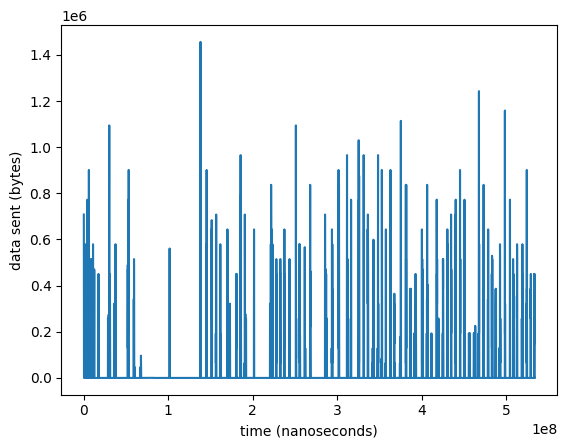

In [68]:
plt.plot(nx - nx.min(), ny)
plt.xlabel("time (nanoseconds)")
plt.ylabel("data sent (bytes)")

In [17]:
yit = -1
iy = 0
f = []
while iy < len(y) - 1:
    if y[iy] == 0:
        iy2 = iy + 1
        while y[iy2] == 0:
            iy2 += 1
        f.append(x[iy2] - x[iy])
        iy = iy2
    else:
        iy += 1
f = np.array(f)

IndexError: list index out of range

In [19]:
f = np.array(f)

In [20]:
f = f / 1000

Text(0.5, 0, 'Density of bursts')

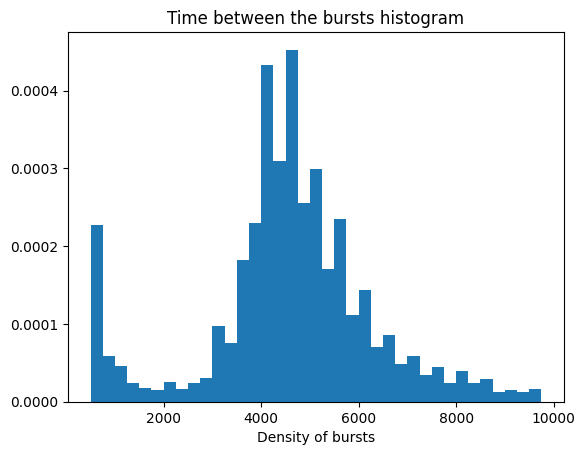

In [70]:
plt.hist(f, bins=np.arange(500, 10000, 250), density=True)
plt.title("Time between the bursts histogram")
plt.xlabel("Time (us)")
plt.xlabel("Density of bursts")

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import polars as pl

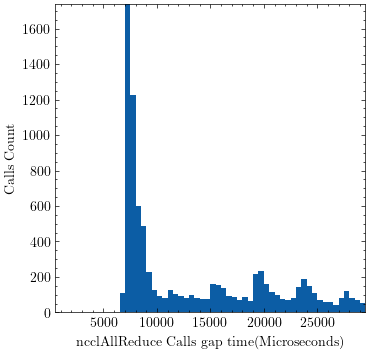

In [6]:
# f = pd.read_csv("../../data/test/node-1/tcpsendmsg", header=None, names=['timestamp', 'value'])
# t = f[f['value'] > 0]['timestamp']
# dt = (t - t.shift())[1:] / 1000
# hist, bins = np.histogram(dt, bins=np.arange(500, 30000, 500))
# hist = hist / len(dt)
# fig, ax = plt.subplots(figsize=(3, 2))
# ax.bar(bins[:-1], hist, width=np.diff(bins), align="edge", label="kmeans")
# plt.xlabel('calls gap time (microseconds)')
# plt.ylabel('Count')
# plt.show()


# f = pd.read_csv("../../data/kmeans/primary/tcpsendmsg", header=None, names=['timestamp', 'value'])
# t = f[f['value'] > 0]['timestamp']
# dt = (t - t.shift())[1:] / 1000
# print(dt.max())
# plt.xlabel('calls gap time (microseconds)')
# plt.ylabel('Count')
# plt.hist(dt, bins=np.arange(500, 20000, 500), density=True, label="kmeans")

# f = pd.read_csv("../../data/pagerank/worker-1/tcpsendmsg", header=None, names=['timestamp', 'value'])
# t = f[f['value'] > 0]['timestamp']
# dt = (t - t.shift())[1:] / 1000
# print(dt.max())
# plt.xlabel('calls gap time (microseconds)')
# plt.ylabel('Count')
# plt.hist(dt, bins=np.arange(500, 20000, 500), density=True, label="pagerank", histtype="step")
# plt.legend()

# f = pd.read_csv("../../data/svm/submit/tcpsendmsg", header=None, names=['timestamp', 'value'])
# t = f[f['value'] > 0]['timestamp']
# dt = (t - t.shift())[1:] / 1000
# print(dt.max())
# plt.xlabel('calls gap time (microseconds)')
# plt.ylabel('Count')
# plt.hist(dt, bins=np.arange(500, 20000, 1000), density=True, label="sgd", histtype="step")
# plt.legend()
# plt.show()

# f = pd.read_csv("../../data/pytorch-mingpt/3/node-1/write", header=None, names=['timestamp', 'value'])
# t = f[f['value'] > 0]['timestamp']
# dt = (t - t.shift())[1:] / 1000
# hist, bins = np.histogram(dt, bins=np.arange(500, 30000, 500))
# # hist = hist / np.sum(hist)
# fig, ax = plt.subplots(figsize=(4, 4))
# ax.bar(bins[:-1], hist, width=np.diff(bins), align="edge", label="kmeans")
# plt.xlabel('tcpsendmsg Calls gap time(Microseconds)')
# plt.ylabel('Calls Count Ratio')
# plt.show()

# f = pd.read_csv("../../data/pytorch-mingpt/3/node-1/tcpsendmsg", header=None, names=['timestamp', 'value'])
# t = f[f['value'] > 0]['timestamp']
# dt = (t - t.shift())[1:] / 1000
# hist, bins = np.histogram(dt, bins=np.arange(500, 30000, 500))
# # hist = hist / np.sum(hist)
# fig, ax = plt.subplots(figsize=(4, 4))
# ax.bar(bins[:-1], hist, width=np.diff(bins), align="edge", label="kmeans")
# plt.xlabel('tcpsendmsg Calls gap time(Microseconds)')
# plt.ylabel('Calls Count Ratio')
# plt.show()

# f = pd.read_csv("../../data/pytorch-mingpt/3/node-1/sendto", header=None, names=['timestamp', 'value'])
# t = f[f['value'] > 0]['timestamp']
# dt = (t - t.shift())[1:] / 1000
# hist, bins = np.histogram(dt, bins=np.arange(500, 30000, 500))
# # hist = hist / np.sum(hist)
# fig, ax = plt.subplots(figsize=(4, 4))
# ax.bar(bins[:-1], hist, width=np.diff(bins), align="edge", label="kmeans")
# plt.xlabel('sendto Calls gap time(Microseconds)')
# plt.ylabel('Calls Count Ratio')
# plt.show()

# f = pd.read_csv("../../data/pytorch-mingpt/3/node-1/sendmsg", header=None, names=['timestamp', 'value'])
# t = f[f['value'] > 0]['timestamp']
# dt = (t - t.shift())[1:] / 1000
# hist, bins = np.histogram(dt, bins=np.arange(500, 30000, 500))
# # hist = hist / np.sum(hist)
# fig, ax = plt.subplots(figsize=(4, 4))
# ax.bar(bins[:-1], hist, width=np.diff(bins), align="edge", label="kmeans")
# plt.xlabel('sendmsg Calls gap time(Microseconds)')
# plt.ylabel('Calls Count Ratio')
# plt.show()


f = pd.read_csv("../../data/pytorch-mingpt/3/node-1/cuda_collective", header=None, names=['timestamp', 'value'])
t = f[f['value'] > 0]['timestamp']
dt = (t - t.shift())[1:] / 1000
hist, bins = np.histogram(dt, bins=np.arange(500, 30000, 500))
# hist = hist / np.sum(hist)
fig, ax = plt.subplots(figsize=(4, 4))
ax.bar(bins[:-1], hist, width=np.diff(bins), align="edge", label="kmeans")
plt.xlabel('ncclAllReduce Calls gap time(Microseconds)')
plt.ylabel('Calls Count')
plt.autoscale(tight=True)
plt.savefig("cuda_collective_pytorch.jpg", dpi=300)

# f = pd.read_csv("../../data/pytorch-mingpt/3/node-1/cuda_allocations", header=None, names=['timestamp', 'value'])
# t = f[f['value'] > 0]['timestamp']
# dt = (t - t.shift())[1:] / 1000
# hist, bins = np.histogram(dt, bins=np.arange(500, 30000, 500))
# # hist = hist / np.sum(hist)
# fig, ax = plt.subplots(figsize=(4, 4))
# ax.bar(bins[:-1], hist, width=np.diff(bins), align="edge", label="kmeans")
# plt.xlabel('cudaMalloc Calls gap time(Microseconds)')
# plt.ylabel('Calls Count Ratio')
# plt.show()

# f = pd.read_csv("../../data/pytorch-mingpt/3/node-1/cuda_broadcast", header=None, names=['timestamp', 'value'])
# t = f[f['value'] > 0]['timestamp']
# dt = (t - t.shift())[1:] / 1000
# hist, bins = np.histogram(dt, bins=np.arange(500, 1200000, 500))
# # hist = hist / np.sum(hist)
# fig, ax = plt.subplots(figsize=(4, 4))
# ax.bar(bins[:-1], hist, width=np.diff(bins), align="edge", label="kmeans")
# plt.xlabel('Calls gap time(Microseconds)')
# plt.ylabel('ncclBroadcast Calls Count Ratio')
# plt.show()

# f = pd.read_csv("../../data/tf-dist-cpu/node-1/sendmsg", header=None, names=['timestamp', 'value'])
# t = f[f['value'] > 0]['timestamp']
# dt = (t - t.shift())[1:] / 1000
# hist, bins = np.histogram(dt, bins=np.arange(500, 30000, 500))
# # hist = hist / np.sum(hist)
# fig, ax = plt.subplots(figsize=(4, 4))
# ax.bar(bins[:-1], hist, width=np.diff(bins), align="edge", label="kmeans")
# plt.xlabel('Calls gap time(Microseconds)')
# plt.ylabel('ncclBroadcast Calls Count Ratio')
# plt.show()

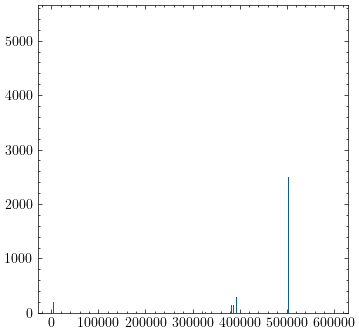

In [22]:
f = pd.read_csv("../../data/pytorch-mingpt/3/node-1/cuda_allocations", header=None, names=['timestamp', 'value'])
t = f[f['value'] > 0]['timestamp']
dt = f['value']
hist, bins = np.histogram(dt, bins=np.arange(500, 600000, 500))
# hist = hist / np.sum(hist)
fig, ax = plt.subplots(figsize=(4, 4))
ax.bar(bins[:-1], hist, width=np.diff(bins), align="edge", label="kmeans")
plt.show()

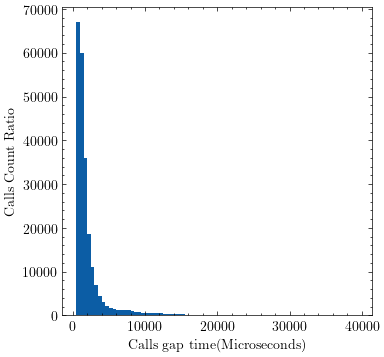

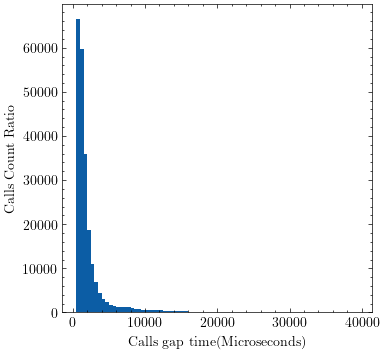

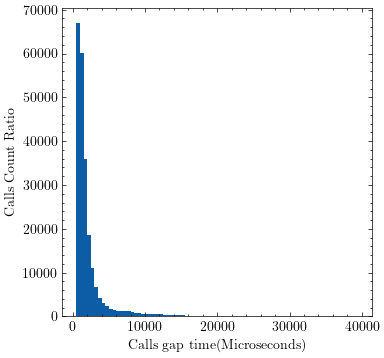

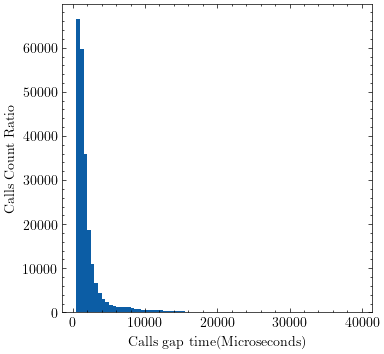

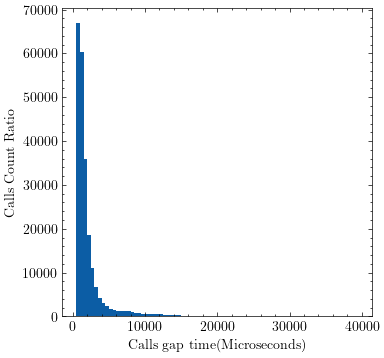

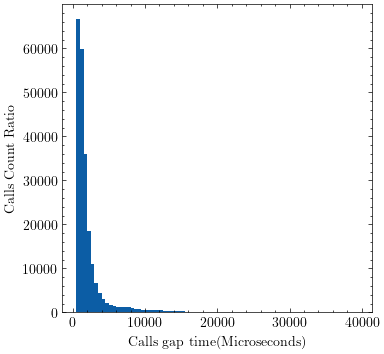

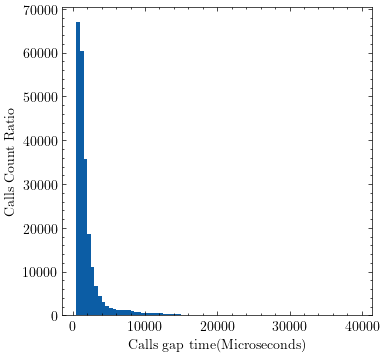

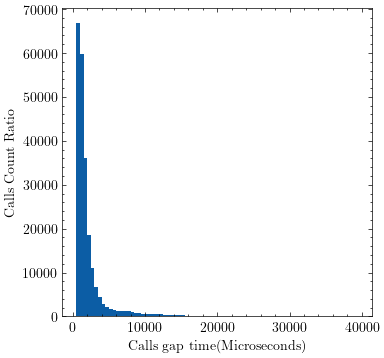

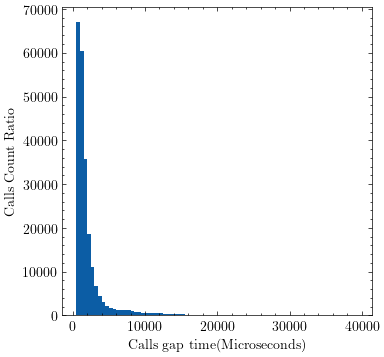

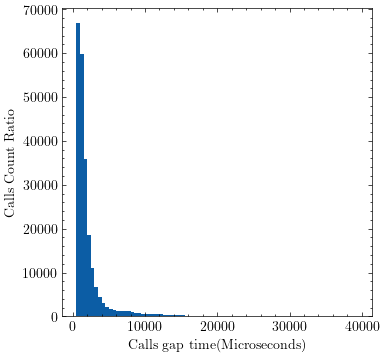

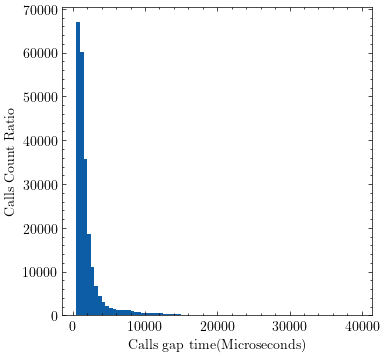

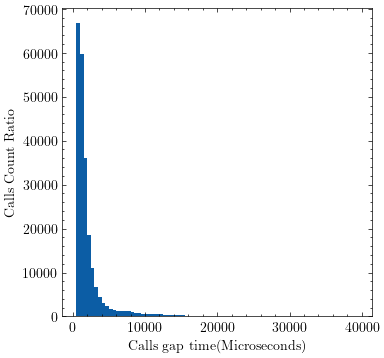

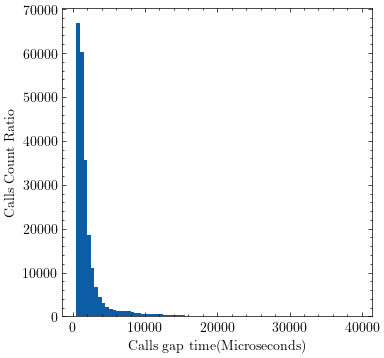

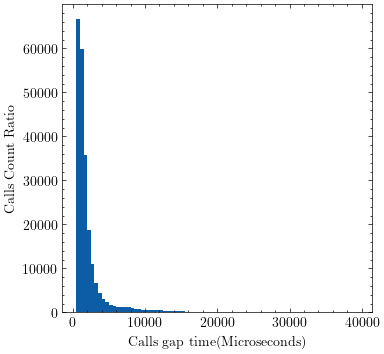

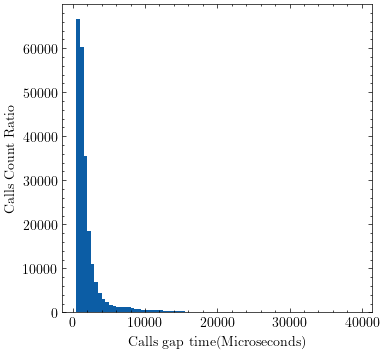

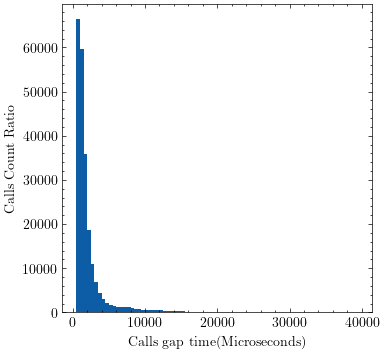

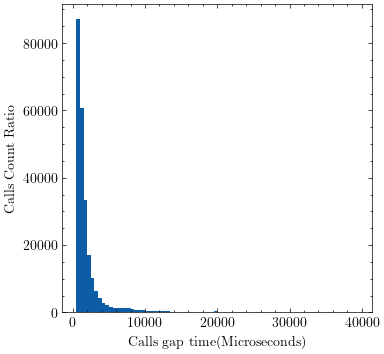

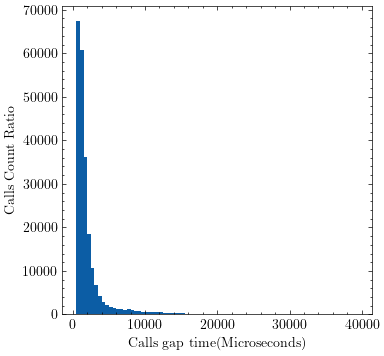

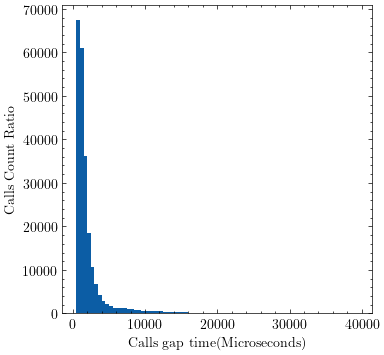

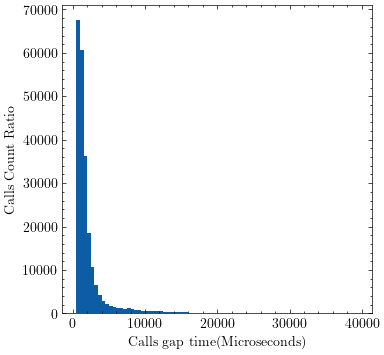

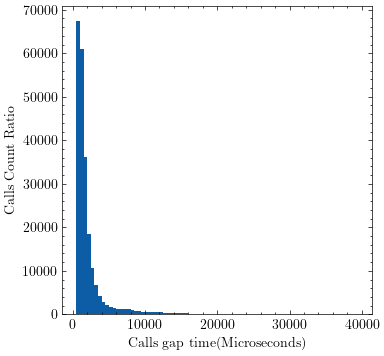

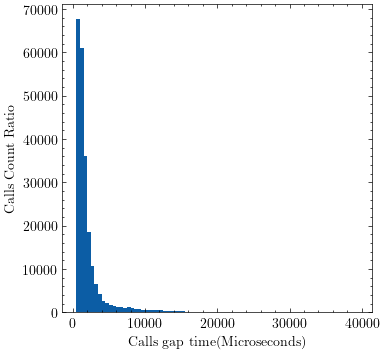

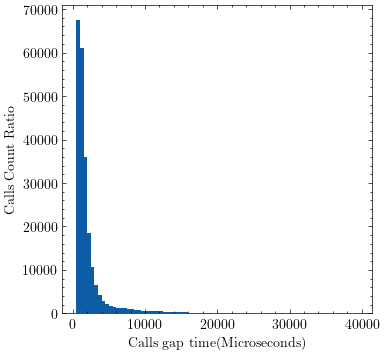

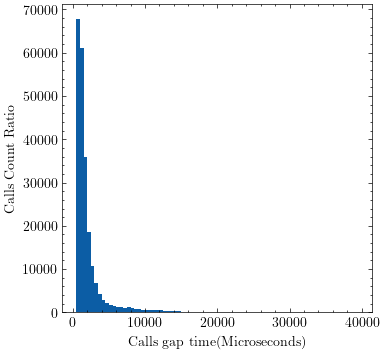

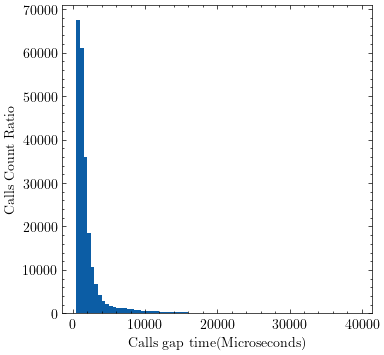

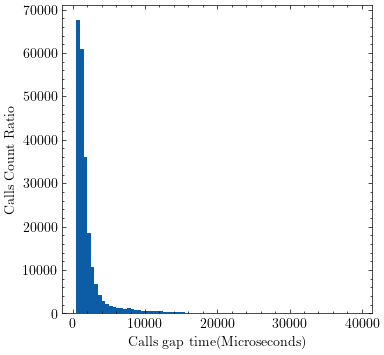

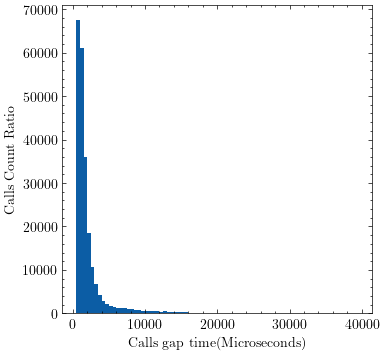

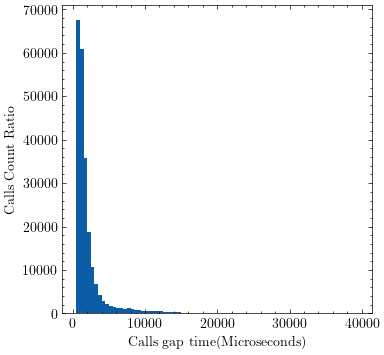

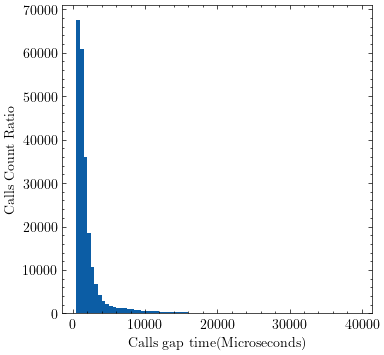

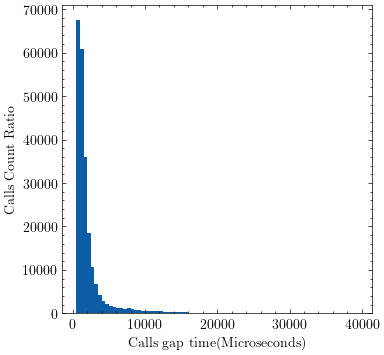

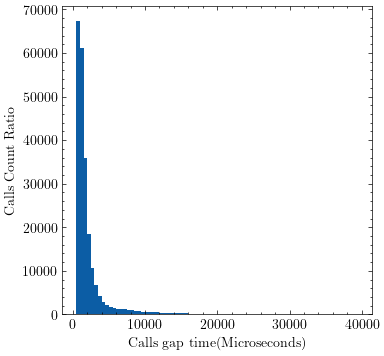

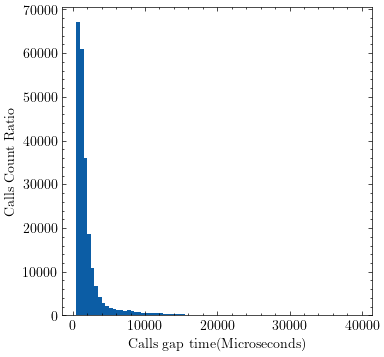

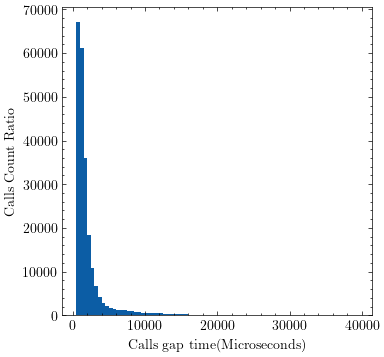

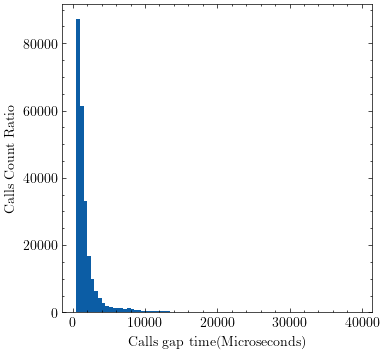

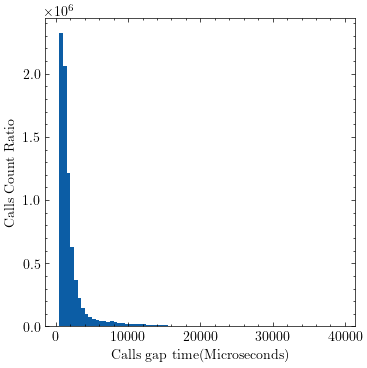

In [26]:
f = pd.read_csv("../../data/pytorch-resnet/3/node-1/sendtofd", header=None, names=['timestamp', 'fd'])
tot = None
for g, t in f.groupby('fd'):
    t = t['timestamp']
    dt = (t - t.shift())[1:] / 1000
    hist, bins = np.histogram(dt, bins=np.arange(500, 40000, 500))
    if tot is None:
        tot = hist
    else:
        tot += hist
    # hist = hist / np.sum(hist)
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.bar(bins[:-1], hist, width=np.diff(bins), align="edge", label="kmeans")
    plt.xlabel('Calls gap time(Microseconds)')
    plt.ylabel('Calls Count Ratio')
    plt.show()
    
fig, ax = plt.subplots(figsize=(4, 4))
ax.bar(bins[:-1], tot, width=np.diff(bins), align="edge", label="kmeans")
plt.xlabel('Calls gap time(Microseconds)')
plt.ylabel('Calls Count Ratio')
plt.show()

In [115]:
f.groupby(['fd']).size().reset_index().rename(columns={0:'count'})

,fd,count
0,56,179414
1,58,179415
2,59,179415
3,60,179415
4,61,179415
5,62,179415
6,63,179415
7,64,179415
8,65,179415
9,66,179415


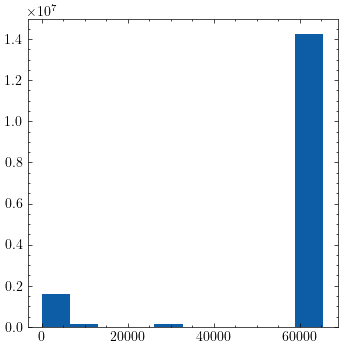

In [38]:
f = pd.read_csv("../../data/pytorch-mingpt/node-0/tcpsendmsg", header=None, names=['timestamp', 'value'])
t = f['value']
hist, bins = np.histogram(t)
fig, ax = plt.subplots(figsize=(4, 4))
ax.bar(bins[:-1], hist, width=np.diff(bins), align="edge", label="kmeans")
plt.show()

In [116]:
f = pd.read_csv("../../data/svm/submit/tcpsendmsg", header=None, names=['timestamp', 'value'])
t = f[f['value'] > 0]['tim']
print(t.std())

f = pd.read_csv("../../data/pagerank/worker-1/tcpsendmsg", header=None, names=['timestamp', 'value'])
t = f[f['value'] > 0]['value']
print(t.std())

f = pd.read_csv("../../data/kmeans/primary/tcpsendmsg", header=None, names=['timestamp', 'value'])
t = f[f['value'] > 0]['value']
print(t.std())

KeyError: 'tim'

(array([0.00000e+00, 2.26000e+02, 2.45022e+05, 1.06293e+05, 2.58060e+04,
        1.45840e+04, 1.08880e+04, 7.79600e+03, 5.97600e+03, 5.39800e+03,
        5.85900e+03, 5.22200e+03, 4.44300e+03, 4.26500e+03, 3.83800e+03,
        3.41500e+03, 3.29200e+03, 3.37100e+03, 4.50500e+03, 4.38900e+03,
        3.29500e+03, 3.12900e+03, 2.99100e+03, 2.94100e+03, 2.75900e+03,
        2.63900e+03, 3.80800e+03, 3.56500e+03, 2.74300e+03, 2.52400e+03,
        2.48000e+03, 2.36200e+03, 2.20400e+03, 2.37000e+03, 3.89100e+03,
        2.86500e+03, 2.06600e+03, 1.85500e+03]),
 array([  500.,  1000.,  1500.,  2000.,  2500.,  3000.,  3500.,  4000.,
         4500.,  5000.,  5500.,  6000.,  6500.,  7000.,  7500.,  8000.,
         8500.,  9000.,  9500., 10000., 10500., 11000., 11500., 12000.,
        12500., 13000., 13500., 14000., 14500., 15000., 15500., 16000.,
        16500., 17000., 17500., 18000., 18500., 19000., 19500.]),
 <BarContainer object of 38 artists>)

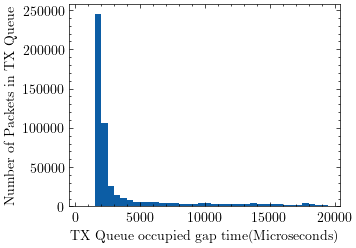

In [32]:
f = pd.read_csv("../../data/pytorch-mingpt/node-0/TXQ", header=None, names=['timestamp', 'value'])
t = f[f['value'] > 0]['timestamp']
dt = (t.diff())[1:] / 1000
plt.xlabel('TX Queue occupied gap time(Microseconds)')
plt.ylabel('Number of Packets in TX Queue')
plt.hist(dt, bins=np.arange(500, 20000, 500))

In [58]:
(f[f['value'] > 10]['timestamp'].diff()[1:] / 1000).mean()

29283.8807691527

In [59]:
(f['timestamp'].diff()[1:] / 1000).mean()

3946.842185434617

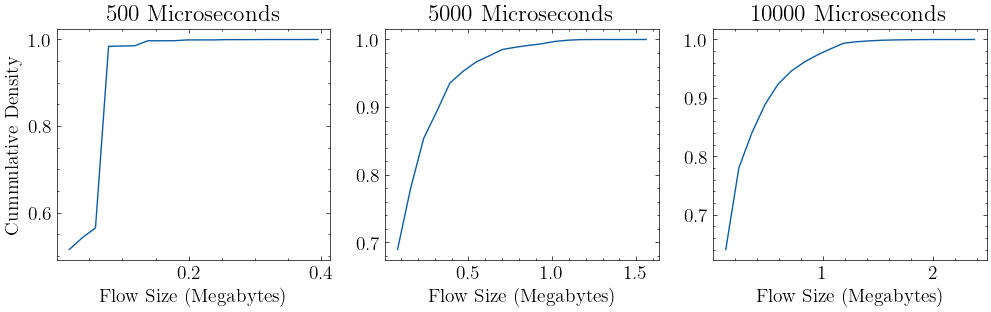

In [16]:
path = "../files-flow-pytorch-mingpt-node-0-to-all-3node-ported/"
times = [500, 5000, 10000]
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
c=0
for t in times:
    flows = pd.read_csv(f"{path}/{t}/flows.csv")['size'].values
    hist, bin_edges = np.histogram(flows, bins=20)
    pdf = hist / np.sum(hist)
    cdf = np.cumsum(pdf)
    if c == 0:
        axs[c].set_ylabel("Cummulative Density")
    axs[c].set_xlabel("Flow Size (Megabytes)")
    axs[c].set_title(f"{t} Microseconds")
    axs[c].plot(bin_edges[1:] / 1024**2, cdf)
    c+=1
plt.savefig("three.pdf", dpi=300)


In [10]:
import seaborn as sns
from matplotlib import pyplot as plt


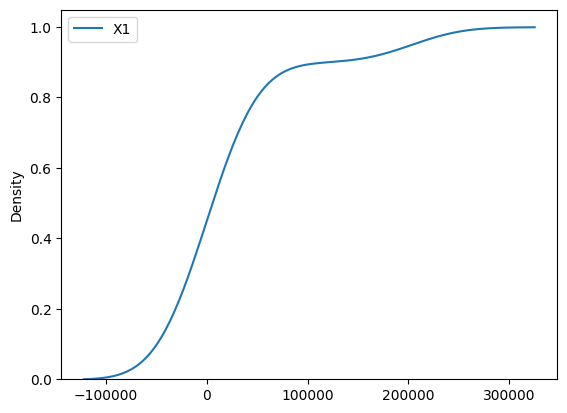

In [51]:
hist

array([203462,    349,    140,     58,     38,     28,     16,      4,
            5,      3])